In [1]:
#Much of the analysis software is contained in this repository
!git clone https://github.com/mattar13/VascularAnalysis
%cd /content/VascularAnalysis

Cloning into 'VascularAnalysis'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 14 (delta 3), reused 13 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (14/14), done.
Resolving deltas: 100% (3/3), done.
/content/VascularAnalysis


In [ ]:
#Import utilities for accessing google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Basic necessities
import random #Random numbers
import numpy as np #Arrays
import pandas as pd #Dataframes
import tifffile as tiff #Opening .tif files
import re

#Plotting utilities
import matplotlib.pyplot as plt #Normal plotting
import seaborn as sns #Fancy plotting
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch

#Stats
from scipy.stats import ranksums #Imports the ranked sum test

In [2]:
from auxillary_functions import insert_zero_rows_between_max_indices, apply_lut

In [ ]:
# @title ### Auxillary Functions
def insert_zero_rows_between_max_indices(data, identifier_info, n=2, category = 'Age'):
    max_indices = {} #This makes a dictionary for the max indices per category
    for k_id in identifier_info[category].unique():
        max_indices[k_id] = identifier_info[identifier_info[category] == k_id].index.max()

    sorted_ages = sorted(max_indices.keys()) #Sort the keys of the dictionary

    #Iterate through the ages and pull out the max index
    for i, age in enumerate(sorted_ages[:-1]):  # Iterate through all but the last age group
        insert_idx = max_indices[age] + 1 + i * n  # Calculate the index where rows should be inserted
        if data.ndim == 3:
            data = np.insert(data, insert_idx, np.zeros((n, data.shape[1], data.shape[2])), axis=0)  # Insert n rows of 0s
        elif data.ndim == 2:
            data = np.insert(data, insert_idx, np.zeros((n, data.shape[1])), axis=0)
        else:
            data = np.insert(data, insert_idx, np.zeros((n)), axis=0)
    return data

# Function to apply LUT
def apply_lut(image, lut):
    """Applies a lookup table to an RGB image."""
    result = np.zeros_like(image)
    for i in range(3):  # Loop over RGB channels
        result[:, :, i] = lut[image[:, :, i]]
    return result

# Organizing data in the dataset

- Open the diving vessel density array
- Open the Slice and Row id for the density array

In [ ]:
# @title ###Open the master datasheet
master_fn = "/content/drive/Shareddrives/Vasculature Data in Python/RawData/FullLeaf_LengthByDistance_REMOVE_BLUE.xlsx"

master_df = pd.read_excel(master_fn)
master_df.fillna(0, inplace = True)
# Remove columns with 'Unnamed' and specified variables
master_df = master_df.loc[:, ~master_df.columns.str.contains('^Unnamed')]
master_df = master_df.drop(columns=['ManualLengthAve', 'ManualLengthNonZeroAve'], errors='ignore')

In [ ]:
# @title ### Open the id associated with the density array
id_fn = "/content/drive/Shareddrives/Vasculature Data in Python/RawData/Diving vessel density files.csv"

id_df = pd.read_csv(id_fn) #Read the csv id file for the density vec
id_df['ImageName'] = id_df['File'].apply(lambda x: re.search(r'- (.*)\.tif', x).group(1) if pd.notna(x) else None)

In [ ]:
# @title ### Open the density array
denArr_fn = "/content/drive/Shareddrives/Vasculature Data in Python/RawData/Diving vessel density vectors.tif"

density_array = tiff.imread(denArr_fn)  # Read all z-stacks

In [ ]:
# @title ### Pull out the column headers starting with X
length_columns = [col for col in master_df.columns if col.startswith('X') and col[1:].isdigit()]
master_lengths = master_df[length_columns]

In [ ]:
# @title ### Create a knee identifier
Knees = np.zeros(master_df.shape[0])
Scores = np.zeros(master_df.shape[0])
#Pick the threshold to order the data by
threshold = 0.01 #Change this threshold if we want this to discover different points
for col in range(1, master_df.shape[0]):
    score = 0 #This is a winning score
    nz_vals_below_thresh = np.where(master_df.iloc[col][length_columns]<threshold)[0]
    nz_vals_above_thresh = np.where(master_df.iloc[col][length_columns]>threshold)[0]
    fBT = fAT = 0 #Zero out all points after the analysis
    lBt = lAT = 0#len(length_columns) #Set the limits to infinity
    #find the First value below the thresh
    if nz_vals_below_thresh.size != 0:
        fBT = nz_vals_below_thresh[0]
        lBT = nz_vals_below_thresh[-1]
    #find the Last value above the thresh
    if nz_vals_above_thresh.size != 0:
        fAT = nz_vals_above_thresh[0]
        lAT = nz_vals_above_thresh[-1]

    Knees[col] = fBT #Set the knee to the first above threshold
    if fBT == 0: #the first above threshold should be 0, if not score is not great
        score += 1
        if fAT >= 10: #This will only fail if the entire array is zero.
            score += 1
        else: #I think it is safe to now assign the knee
            Knees[col] = lAT #Set the knee to the first above threshold

    Scores[col] = score

master_df.insert(master_df.shape[1], "Knee", Knees)
master_df.insert(master_df.shape[1], "Score", Scores)

In [ ]:
#Pull out the columns with ID info (has to be done here)
identifier_columns = [col for col in master_df.columns if not col.startswith('X')]
master_ids = master_df[identifier_columns]

# Seperate the data into superficial, deep and intermediate

In [ ]:
# @title ### Separate the data based on the layer (Superficial, Deep, Intermediate)
superficial_data = master_df[master_df['Layer'] == 'Superficial'].reset_index(drop=True) #Every datapoint should have sup data
deep_data = master_df[master_df['Layer'] == 'Deep']
intermediate_data = master_df[master_df['Layer'] == 'Intermediate']

In [ ]:
# @title ### Create the identification sheet similar to superficial_data but without the 'Layer' column
identification_sheet = superficial_data.drop(columns=['Knee', 'Layer', 'Score']).copy()
identification_sheet = identification_sheet.drop(columns = length_columns)

In [ ]:
# @title ### Aligning data so that every layer has corresponding superficial data
aligned_density_data = np.zeros((len(superficial_data), len(length_columns), 3))
aligned_diving_data = np.zeros((len(superficial_data), len(length_columns), 3))
# Add Superficial Knee, Deep Knee, and Intermediate Knee columns to the identification sheet
identification_sheet['KneeSup'] = superficial_data['Knee']
# Match Deep and Intermediate data based on 'Exp Date' and 'Exp Number'
for idx, row in superficial_data.iterrows():
    exp_id = row['ExpNum'] #This
    replicate = row['Replicate'] #This
    ImageName = row['ImageName'] #and this are identifiers

    # Find matching row in deep_data
    deep_row = deep_data[
        (deep_data['ExpNum'] == exp_id) &
         (deep_data['Replicate'] == replicate) &
          (deep_data['ImageName'] == ImageName)]
    intermediate_row = intermediate_data[
          (intermediate_data['ExpNum'] == exp_id) &
           (intermediate_data['Replicate'] == replicate) &
            (intermediate_data['ImageName'] == ImageName)]

    aligned_density_data[idx, :, 0] = row[length_columns].values  # Superficial layer

    # Find matching row in intermediate_data
    if not intermediate_row.empty:
        identification_sheet.at[idx, 'KneeInt'] = intermediate_row.iloc[0]['Knee']
        aligned_density_data[idx, :, 1] = intermediate_row[length_columns].values  # Intermediate layer

    #This is to merge identification_sheets and aligned_density_data
    if not deep_row.empty:
        identification_sheet.at[idx, 'KneeDeep'] = deep_row.iloc[0]['Knee']
        aligned_density_data[idx, :, 2] = deep_row[length_columns].values  # Deep layer

    #This section is for merging the diving data arrays
    matching_rows = id_df[id_df['ImageName'] == ImageName] #Pull out id row
    for _, MATCH in matching_rows.iterrows(): #Iterate through each match and pull out
        #print(f"Slice: {match['Slice']}, Row: {match['Row']}")
        rows = density_array[MATCH['Slice']-1, :, MATCH['Row']-1, :]
        rows[np.isnan(rows)] = 0.0
        aligned_diving_data[idx, :, 0] = rows[0, :] #Extract the sup. to int.
        aligned_diving_data[idx, :, 1] = rows[1, :] #Extract the int. to deep.
        aligned_diving_data[idx, :, 2] = np.zeros(rows.shape[1])


In [ ]:
# @title ### Sort the data by age, quadrant, and the deep knee
sorting_keys = pd.DataFrame({
    'Age': identification_sheet['Age'],
    'Quadrant': identification_sheet['Quadrant'],
    'Knee_Deep': identification_sheet['KneeDeep']  # Column 1 corresponds to the deep layer
})

#sorting_keys_sorted = sorting_keys.sort_values(by=['Age', 'Quadrant', 'KneeDeep'], ascending=[True, True, True])
identification_sheet = identification_sheet.sort_values(by=['Age', 'KneeDeep'], ascending=[True, True])
sorted_indices = identification_sheet.index
identification_sheet = identification_sheet.reset_index(drop = True)

In [ ]:
# Extract rows that begin with 'Knee' from the identification_sheet
knee_data = identification_sheet.filter(regex='^Knee', axis=1).to_numpy()

In [ ]:
#Sort the aligned data
aligned_density_data = aligned_density_data[sorted_indices]
aligned_diving_data = aligned_diving_data[sorted_indices]

In [ ]:
#We want to make seperate datasheets for each frame
sup_dens_sheet = pd.DataFrame(aligned_density_data[:, :, 0], columns=length_columns)
int_dens_sheet = pd.DataFrame(aligned_density_data[:, :, 1], columns=length_columns)
deep_dens_sheet = pd.DataFrame(aligned_density_data[:, :, 2], columns=length_columns)

sup_dive_sheet = pd.DataFrame(aligned_diving_data[:, :, 0], columns=length_columns)
int_dive_sheet = pd.DataFrame(aligned_diving_data[:, :, 1], columns=length_columns)

In [ ]:
#Convert the heatmaps into numpy arrays
sup_dens_arr = sup_dens_sheet.to_numpy()
int_dens_arr = int_dens_sheet.to_numpy()
deep_dens_arr = deep_dens_sheet.to_numpy()

#Open the diving sheets
sup_dive_arr = sup_dive_sheet.to_numpy()
int_dive_arr = int_dive_sheet.to_numpy()

# Save the data here when you are ready

In [ ]:
output_excel_fn = '/content/drive/Shareddrives/Vasculature Data in Python/RawData/MasterSheet.xlsx'
with pd.ExcelWriter(output_excel_fn) as writer:
    identification_sheet.to_excel(writer, sheet_name='Identification_Sheet', index=False)
    sup_dens_sheet.to_excel(writer, sheet_name='Sup_Dens_Sheet', index=False)
    int_dens_sheet.to_excel(writer, sheet_name='Int_Dens_Sheet', index=False)
    deep_dens_sheet.to_excel(writer, sheet_name='Deep_Dens_Sheet', index=False)
    sup_dive_sheet.to_excel(writer, sheet_name='Sup_Diving_Sheet', index=False)
    int_dive_sheet.to_excel(writer, sheet_name='Int_Diving_Sheet', index=False)

# Run the stats here

In [ ]:
# @title ### Age, Layer, and Genotype
ages = identification_sheet['Age'].unique()
quadrants = identification_sheet['Quadrant'].unique()
genotypes = identification_sheet['Genotype'].unique() #This is our comparator

#Pull out unique identifiers for each mouse.
unique_dates = identification_sheet['ExpDate'].unique()

# Display some of the data here

In [ ]:
identification_sheet[identification_sheet["Age"] == 8.0].sort_values(by = 'Mouse ID')

,ExpDate,ExpNum,Replicate,ImageName,Age,Genotype,Eye,Quadrant,Magnification,Mouse ID,KneeSup,KneeDeep,KneeInt
76,230801.0,53.0,1.0,230801_003,8.0,B2,left,0,20x,P1,22.0,0.0,NaN
96,230801.0,53.0,1.0,230801_004,8.0,B2,left,0,20x,P1,27.0,1.0,NaN
97,230801.0,53.0,1.0,230801_002,8.0,B2,left,0,20x,P1,21.0,4.0,NaN
78,230802.0,53.0,1.0,230802_004,8.0,WT,right,0,20x,P2,22.0,0.0,NaN
77,230802.0,53.0,1.0,230802_001,8.0,WT,right,0,20x,P2,23.0,0.0,NaN
79,240418.0,79.0,2.0,240418_002,8.0,WT,Left,ventral,20x,P3,24.0,0.0,NaN
85,240419.0,79.0,2.0,240419_004,8.0,WT,Right,nasal,20x,P3,30.0,0.0,NaN
84,240419.0,79.0,2.0,240419_003,8.0,WT,Right,ventral,20x,P3,26.0,0.0,NaN
86,240419.0,79.0,2.0,240419_005,8.0,WT,Right,dorsal,20x,P3,23.0,0.0,NaN
82,240418.0,79.0,2.0,240418_005,8.0,WT,Left,nasal,20x,P3,23.0,0.0,NaN


In [ ]:
identification_sheet[identification_sheet["Age"] == 14.0]

,ExpDate,ExpNum,Replicate,ImageName,Age,Genotype,Eye,Quadrant,Magnification,Mouse ID,KneeSup,KneeDeep,KneeInt
221,240205.0,74.0,1.0,240205_003,14.0,B2,right,temporal,20x,P2,27.0,24.0,18.0
222,240515.0,80.0,2.0,240515_011,14.0,B2,right,temporal,20x,P3,26.0,24.0,11.0
223,240515.0,80.0,2.0,240515_014,14.0,B2,right,dorsal,20x,P3,25.0,24.0,22.0
224,240705.0,80.0,2.0,240705_001,14.0,B2,left,nasal,20x,P3,24.0,24.0,9.0
225,240207.0,74.0,1.0,240207_003,14.0,WT,left,temporal,20x,P1,27.0,25.0,25.0
226,240425.0,74.0,1.0,240425_004,14.0,B2,left,temporal,20x,P2,26.0,25.0,18.0
227,240701.0,80.0,2.0,240701_004,14.0,B2,left,ventral,20x,P3,25.0,25.0,18.0
228,240723.0,80.0,2.0,240723_004,14.0,WT,left,nasal,20x,P4,27.0,25.0,22.0
229,240723.0,80.0,2.0,240723_005,14.0,WT,left,ventral,20x,P4,27.0,25.0,22.0
230,240205.0,74.0,1.0,240205_004,14.0,B2,right,nasal,20x,P2,27.0,26.0,25.0


ExpDate            240125.0
ExpNum                 74.0
Replicate               1.0
ImageName        240125_001
Age                    14.0
Genotype                 WT
Eye                   right
Quadrant             dorsal
Magnification           20x
Mouse ID                 P1
KneeSup                28.0
KneeDeep               28.0
KneeInt                27.0
Name: 240, dtype: object


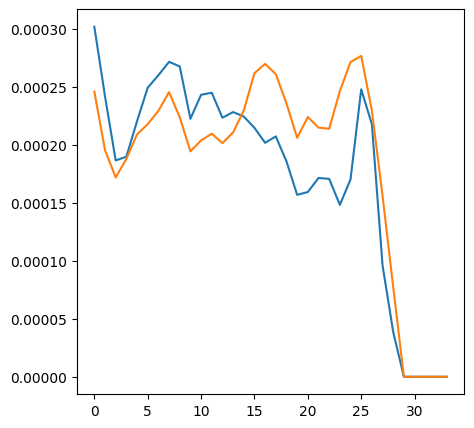

In [ ]:
idx = 240
print(identification_sheet.iloc[idx, :])
fig1, axes = plt.subplots(1, 1, figsize=(5, 5), sharey=True)
axes.plot(sup_dive_arr[idx, :], label = "sup->int")
axes.plot(int_dive_arr[idx, :], label = "")

ExpDate            240425.0
ExpNum                 74.0
Replicate               1.0
ImageName        240425_002
Age                    14.0
Genotype                 B2
Eye                    left
Quadrant              nasal
Magnification           20x
Mouse ID                 P2
KneeSup                26.0
KneeDeep               27.0
KneeInt                25.0
Name: 238, dtype: object


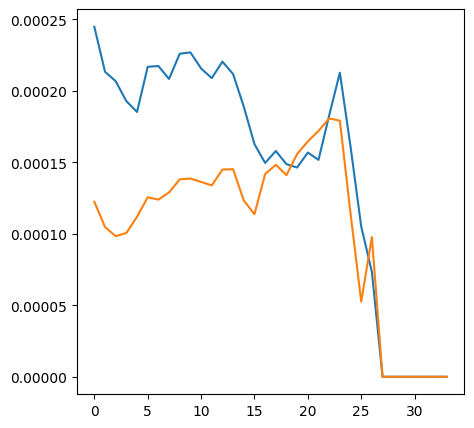

In [ ]:
idx = 238
print(identification_sheet.iloc[idx, :])
fig1, axes = plt.subplots(1, 1, figsize=(5, 5), sharey=True)
axes.plot(sup_dive_arr[idx, :])
axes.plot(int_dive_arr[idx, :])